In [1]:
!pip install transformers datasets torchaudio librosa numpy scikit-learn soundfile matplotlib torchsummary

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn.functional as F
import librosa.display as ldsp
from torch import nn
from datasets import load_dataset, Audio
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchaudio.transforms import Resample, MelSpectrogram, AmplitudeToDB
from torchsummary import summary
from timeit import default_timer as dtimer
from warnings import filterwarnings

In [3]:
# Ignore warnings and set seeds for random functions
filterwarnings('ignore')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [4]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [5]:
# Load the GTZAN dataset
dataset = load_dataset("marsyas/gtzan", "all", trust_remote_code=True)

print(dataset)

gtzan.py:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

genres.tar.gz:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})


In [6]:
# Store class names
class_names = dataset['train'].features['genre'].names

# Converting our dataset's sampling rate to 16k
sampling_rate = 16000
dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [7]:
# Train test split
dataset = dataset['train'].train_test_split(seed=42, shuffle=True, test_size=0.1, stratify_by_column='genre')
train_dataset = dataset['train']
test_dataset = dataset['test']

In [8]:
# Preprocessing function
def preprocess(batch, target_length = 30):
    target_bound = target_length * sampling_rate
    waveform = batch["audio"]["array"]

    waveform = torch.FloatTensor(waveform)

    if waveform.size(0) < target_bound:
        # Zero-pad if shorter
        padding = target_bound - waveform.size(0)
        waveform = F.pad(waveform, (0, padding))
    else:
        # Truncate if longer
        waveform = waveform[:target_bound]

    batch["input_values"] = waveform
    batch["labels"] = int(batch["genre"])
    return batch

In [9]:
# Apply preprocessing
train_dataset = dataset['train'].map(preprocess, remove_columns=["audio", "genre", "file"], num_proc=os.cpu_count(), load_from_cache_file=True)
train_dataset.set_format("pt", columns=["input_values", "labels"], output_all_columns=True)

test_dataset = dataset['test'].map(preprocess, remove_columns=["audio", "genre", "file"], num_proc=os.cpu_count(), load_from_cache_file=True)
test_dataset.set_format("pt", columns=["input_values", "labels"], output_all_columns=True)

# free dataset memory
del dataset

Map (num_proc=4):   0%|          | 0/899 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

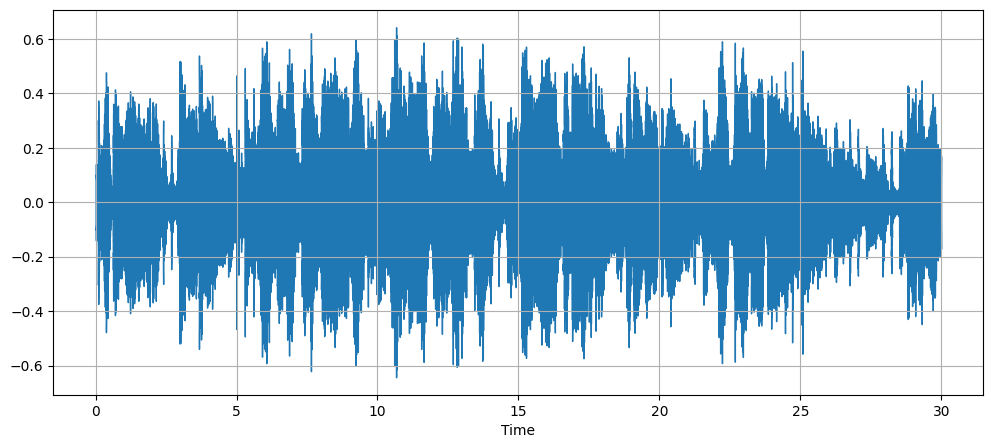

In [10]:
# plot sample audio from training data
waveform = train_dataset[0]["input_values"]
waveform = waveform.numpy()
plt.figure(figsize=(12,5))
ldsp.waveshow(waveform, sr=sampling_rate)
plt.grid(True)
plt.show()

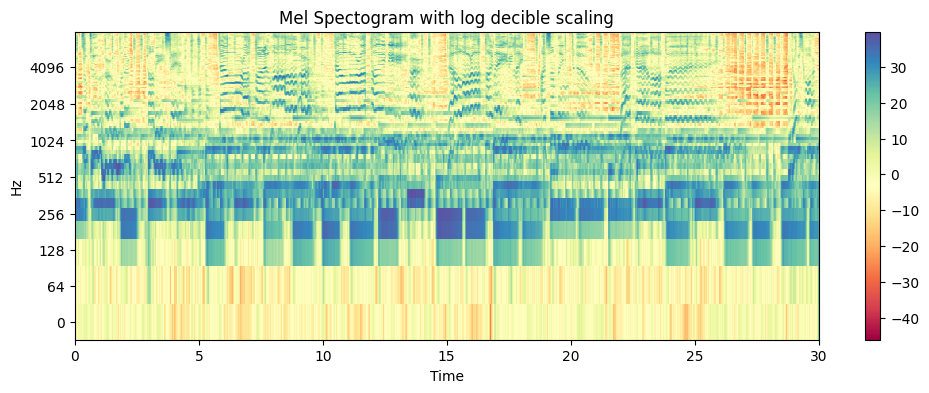

In [11]:
# Plot mel spectogram with log decible scaling
waveform = train_dataset[0]["input_values"]
melSpectogram = MelSpectrogram(sample_rate=16000,n_fft=2048,hop_length=512,n_mels=128)
amplitudeDB = AmplitudeToDB()
scaled_wave = amplitudeDB(melSpectogram(waveform)).numpy()
plt.figure(figsize=(12,4))
ldsp.specshow(scaled_wave, sr=sampling_rate, x_axis='time', y_axis='log', cmap='Spectral')
plt.colorbar()
plt.title("Mel Spectogram with log decible scaling")
plt.show()

In [12]:
# Pipeline to perform Mel spectogram on audio
class MusicProcessor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ):
        super().__init__()
        self.melSpectogram = MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )

        self.convert_DB = AmplitudeToDB()

    def forward(self, waveform):

        # Mel spectogram
        mel = self.melSpectogram(waveform)

        #Convert to decible
        mel = self.convert_DB(mel)

        #Add channel dimension
        mel = mel.unsqueeze(0)

        return mel

In [13]:
# Instantiate a pipeline
processor = MusicProcessor()

# Move to GPU if available
processor.to(device=device, dtype=torch.float32)

# Initialize data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8
)

In [14]:
# Self attention module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()

        # Get query, key, value projections
        query = self.query(x).view(batch_size, -1, H*W)  # B, C/8, N
        key = self.key(x).view(batch_size, -1, H*W)      # B, C/8, N
        value = self.value(x).view(batch_size, -1, H*W)  # B, C, N

        # Calculate attention scores
        attention = torch.bmm(query.permute(0, 2, 1), key)  # B, N, N
        attention = F.softmax(attention, dim=-1)

        # Apply attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))  # B, C, N
        out = out.view(batch_size, C, H, W)

        # Residual connection
        return self.gamma * out + x


In [15]:
# Channel attention module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels)
        )

    def forward(self, x):
        batch_size, C, _, _ = x.size()

        # Average pooling
        avg_out = self.avg_pool(x).view(batch_size, C)
        avg_out = self.fc(avg_out)

        # Max pooling
        max_out = self.max_pool(x).view(batch_size, C)
        max_out = self.fc(max_out)

        # Combine and apply sigmoid
        out = avg_out + max_out
        attention = torch.sigmoid(out).view(batch_size, C, 1, 1)

        return x * attention


In [16]:
# Define classifier
class MusicGenreClassifier(nn.Module):
    def __init__(self, num_genres=10):
        super(MusicGenreClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(128)

        # Attention modules
        self.self_attention1 = SelfAttention(64)
        self.self_attention2 = SelfAttention(128)
        self.channel_attention1 = ChannelAttention(64)
        self.channel_attention2 = ChannelAttention(128)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduces to (batch_size, channels, 1, 1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Activation function
        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_genres)

    def forward(self, x):
        # First conv block
        x = self.pool(self.relu(self.bn1(self.conv1(x))))

        # Second conv block with attention
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.self_attention1(x)
        x = self.channel_attention1(x)

        # Third conv block with attention
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.self_attention2(x)
        x = self.channel_attention2(x)

        # Fourth conv block
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)

        x = x.view(x.size(0), -1)    # Flatten to (batch_size, 256)

        x = self.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [17]:
# Print the model summary
model_info = MusicGenreClassifier().to(device)

channel = 1
xdim = 128
ydim = 938

print(summary(model_info, input_size=(channel, xdim, ydim)))

# Free up memory
del model_info

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 938]             320
       BatchNorm2d-2         [-1, 32, 128, 938]              64
              ReLU-3         [-1, 32, 128, 938]               0
         MaxPool2d-4          [-1, 32, 64, 469]               0
            Conv2d-5          [-1, 64, 64, 469]          18,496
       BatchNorm2d-6          [-1, 64, 64, 469]             128
              ReLU-7          [-1, 64, 64, 469]               0
         MaxPool2d-8          [-1, 64, 32, 234]               0
            Conv2d-9           [-1, 8, 32, 234]             520
           Conv2d-10           [-1, 8, 32, 234]             520
           Conv2d-11          [-1, 64, 32, 234]           4,160
    SelfAttention-12          [-1, 64, 32, 234]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                   

In [18]:
# Initialize the model for classification
model = MusicGenreClassifier()

# Send model to GPU if available
model = model.to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [19]:
# Training loop
def train(model, train_loader, optimizer):
    model.train()
    for i, batch in enumerate(train_loader):
        input_values = batch["input_values"]
        input_values = input_values.to(device)
        input_values = processor(input_values).permute(1, 0, 2, 3)
        labels = batch["labels"].to(device)
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [20]:
# Evaluation loop
def evaluate(model, data_loader):
    model.eval()
    preds, targets = [], []
    avg_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_values = batch["input_values"]
            input_values = input_values.to(device)
            input_values = processor(input_values).permute(1, 0, 2, 3)
            labels = batch["labels"].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            avg_batch_loss = loss.item() / len(labels)
            preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
            avg_loss += avg_batch_loss

        avg_loss = avg_loss / len(data_loader)

    return avg_loss, preds, targets


In [21]:
# Training and evaluation process
epochs = 50
start_time = dtimer()
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(epochs):
    train(model, train_loader, optimizer)
    train_loss, train_preds, train_targets = evaluate(model, train_loader)
    train_acc = accuracy_score(train_targets, train_preds)
    test_loss, test_preds, test_targets = evaluate(model, test_loader)
    acc = accuracy_score(test_targets, test_preds)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc*100)
    test_accuracies.append(acc*100)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {acc:.4f}")

total_time = round((dtimer() - start_time)/60, 2)
print(f"The model has taken {total_time} minutes to train")


Epoch 1, Train Loss: 0.2360, Train Accuracy: 0.3737, Test Loss: 0.2499, Test Accuracy: 0.3400
Epoch 2, Train Loss: 0.2190, Train Accuracy: 0.4583, Test Loss: 0.2308, Test Accuracy: 0.4600
Epoch 3, Train Loss: 0.2090, Train Accuracy: 0.4939, Test Loss: 0.2192, Test Accuracy: 0.5200
Epoch 4, Train Loss: 0.1933, Train Accuracy: 0.5462, Test Loss: 0.2071, Test Accuracy: 0.5800
Epoch 5, Train Loss: 0.1810, Train Accuracy: 0.5373, Test Loss: 0.1982, Test Accuracy: 0.5400
Epoch 6, Train Loss: 0.1741, Train Accuracy: 0.5907, Test Loss: 0.1920, Test Accuracy: 0.5700
Epoch 7, Train Loss: 0.1699, Train Accuracy: 0.5873, Test Loss: 0.1872, Test Accuracy: 0.6000
Epoch 8, Train Loss: 0.1620, Train Accuracy: 0.6218, Test Loss: 0.1850, Test Accuracy: 0.6200
Epoch 9, Train Loss: 0.1698, Train Accuracy: 0.5940, Test Loss: 0.1844, Test Accuracy: 0.6100
Epoch 10, Train Loss: 0.1626, Train Accuracy: 0.6207, Test Loss: 0.1811, Test Accuracy: 0.6700
Epoch 11, Train Loss: 0.1479, Train Accuracy: 0.6574, Test 

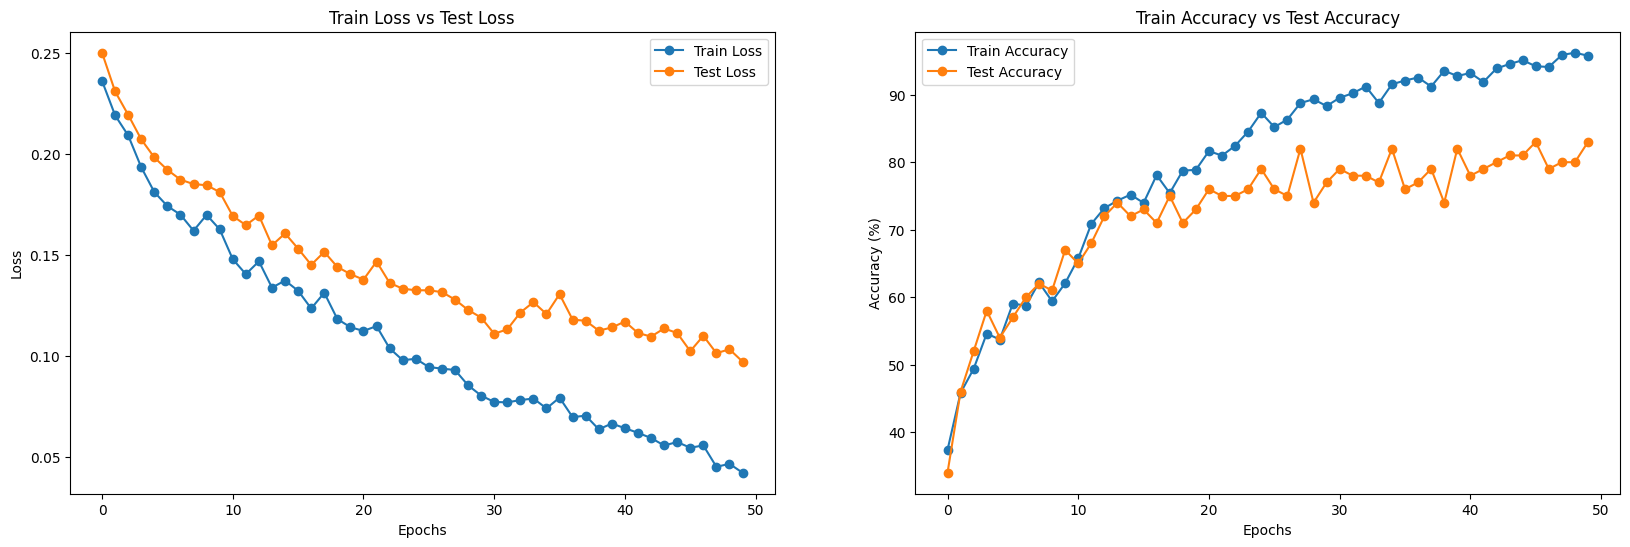

In [22]:
# Plot Epoch vs Loss and Epoch vs Accuracy plots
plt.figure(figsize=(20, 6))

# Plot Train Loss vs Test Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss', marker='o')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()

# Plot Train Accuracy vs Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy vs Test Accuracy')
plt.legend()

# Display the plots
plt.show()

In [23]:
# Classification report
print(classification_report(test_targets, test_preds, target_names=class_names))

              precision    recall  f1-score   support

       blues       1.00      0.60      0.75        10
   classical       0.90      0.90      0.90        10
     country       0.71      1.00      0.83        10
       disco       0.80      0.80      0.80        10
      hiphop       0.82      0.90      0.86        10
        jazz       1.00      0.80      0.89        10
       metal       0.69      0.90      0.78        10
         pop       1.00      0.90      0.95        10
      reggae       1.00      0.70      0.82        10
        rock       0.67      0.80      0.73        10

    accuracy                           0.83       100
   macro avg       0.86      0.83      0.83       100
weighted avg       0.86      0.83      0.83       100



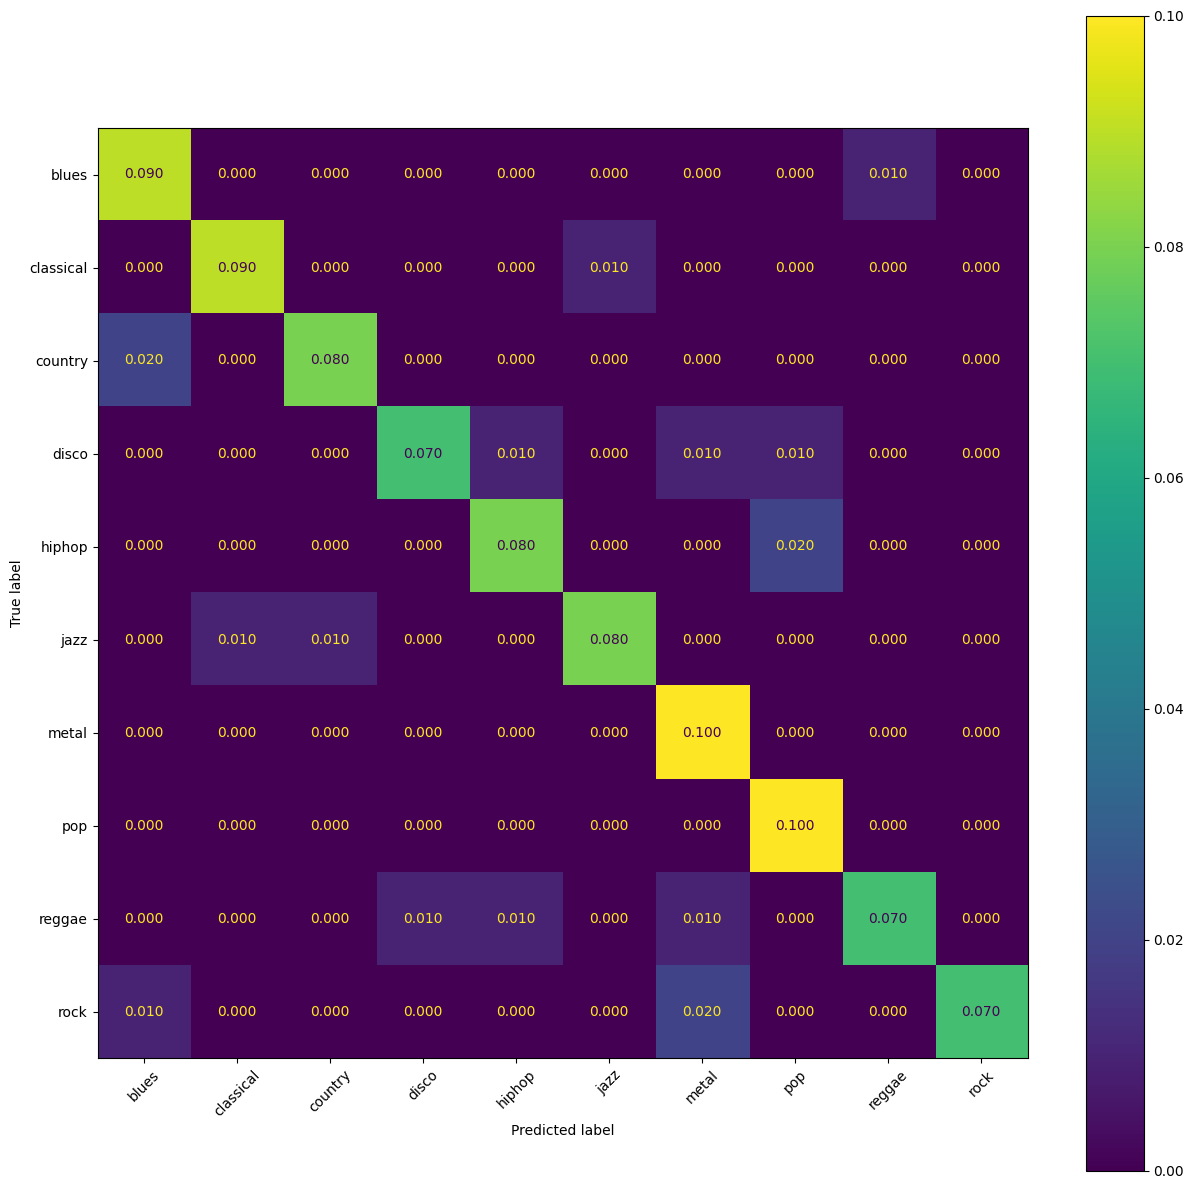

In [24]:
# Confusion matrix
cm = confusion_matrix(test_targets, test_preds, normalize='all')
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax, values_format='.3f', xticks_rotation=45)